****
# RNN / LSTM / GRU to predict Hedge Funds flows in Commodities Markets using TensorFlow / Keras
****
<p style="text-align: right"><i>Jesus Perez Colino<br>First version: December 2019<br></i></p>

## About this notebook: 
****
Notebook prepared by **Jesus Perez Colino** Version 0.2, First Released: 25/11/2019, Alpha

- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.


- **Summary**: 

This is the **simplest** possible Neural Network, and the **simplest** example that I think of, to show how a **Neural Network works for financial Time-Series prediction**. This is just *for learning purposes*, and it is not intended as an example of professional or 'production' prediction model. Here, we present, in the simplest possible way (using Keras with TensorFlow as backend), how a **Recurrent Neural Network (RNN)**, **Long-Short Term Memory (LSTM)** neural network and **Gated Recurrent Unit (GRU)** neural network will perform to predict the net position of hedge funds in a commodity market (data source: COT-report from CFTC, using quandl).

- **Index**:

    1. Extracting the original time series
    2. Feature Engineering on the original data
    3. Recurrent Neural Network (RNN) 
    4. Long-Short Term Memmory (LSTM)
    5. Gated Recurrent Units (GRU)
    6. Summary of results

In [1]:
import quandl as ql
import numpy as np
np.random.seed(12345)

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
tf.set_random_seed(12345)
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
import matplotlib.pyplot as plt
import watermark

import warnings
warnings.filterwarnings('ignore')

%load_ext watermark
%matplotlib inline

Using TensorFlow backend.


In [2]:
ql.ApiConfig.api_key = 'INSERT_YOUT_TOKEN_HERE'

In [3]:
print(' Reproducibility conditions for this notebook '.center(85,'-'))
%watermark -n -v -m -p numpy,scipy,tensorflow,keras,matplotlib,sklearn,pandas
print('-'*85)

-------------------- Reproducibility conditions for this notebook -------------------
Sun Dec 08 2019 

CPython 3.7.4
IPython 7.8.0

numpy 1.16.5
scipy 1.3.1
tensorflow 1.15.0
keras 2.2.4
matplotlib 3.1.1
sklearn 0.21.3
pandas 0.25.1

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
-------------------------------------------------------------------------------------


## 1. Extracting the original time series

In [4]:
cot_WTI = pd.DataFrame(ql.get('CFTC/067411_FO_ALL', start_date='2009-01-01'))
MM_net_WTI = pd.DataFrame(cot_WTI['Money Manager Longs']-cot_WTI['Money Manager Shorts'],
                          columns=['MM_Net_Position'])

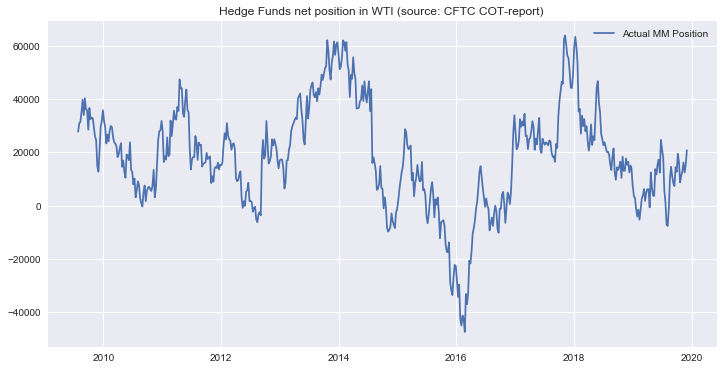

In [5]:
plt.style.use('seaborn')
plt.plot(MM_net_WTI.index, MM_net_WTI.values, label='Actual MM Position')
plt.title('Hedge Funds net position in WTI (source: CFTC COT-report) ')
plt.legend()
plt.gcf().set_size_inches(12,6)

## 2. Feature Engineering on the original data

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
input_data = scaler.fit_transform(MM_net_WTI)

In [7]:
n_points = input_data.shape[0]
train_points = int(2/3*n_points)+1

train, test = input_data[:train_points], input_data[train_points:]

In [8]:
X_train, X_test = train[:-1], test[:-1]
y_train, y_test = train[1:], test[1:]

print("Sample sets split (training/testing):", 
      len(X_train), "training points and", 
      X_test.shape[0], "testing points")

Sample sets split (training/testing): 360 training points and 179 testing points


In [15]:
tf.reset_default_graph()
keras.backend.clear_session()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)
print(X_test.shape)

(360, 1, 1)
(179, 1, 1)


## 3. Recurrent Neural Network (RNN) 

In [16]:
RNN_model = Sequential()
RNN_model.add(SimpleRNN(units=8, input_shape=(X_train.shape[1], X_train.shape[2])))
RNN_model.add(Dense(1))

RNN_model.compile(loss='mean_squared_error', optimizer='adam')

RNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 8)                 80        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [17]:
nb_epoch = 20
batch_size = 1

history = RNN_model.fit(X_train, y_train, epochs=nb_epoch, verbose=1, batch_size=batch_size, shuffle=False)

Epoch 1/20
360/360 [==============================] - 1s 3ms/step - loss: 0.0095
Epoch 2/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 3/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 4/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 5/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 6/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 7/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 8/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 9/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 10/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 11/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 12/20
360/360 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 13/20
360/360 [====

In [18]:
RNN_y_train_pred = RNN_model.predict(X_train)
RNN_y_test_pred = RNN_model.predict(X_test)
RNN_y_train_pred = scaler.inverse_transform(RNN_y_train_pred)
RNN_y_test_pred = scaler.inverse_transform(RNN_y_test_pred)

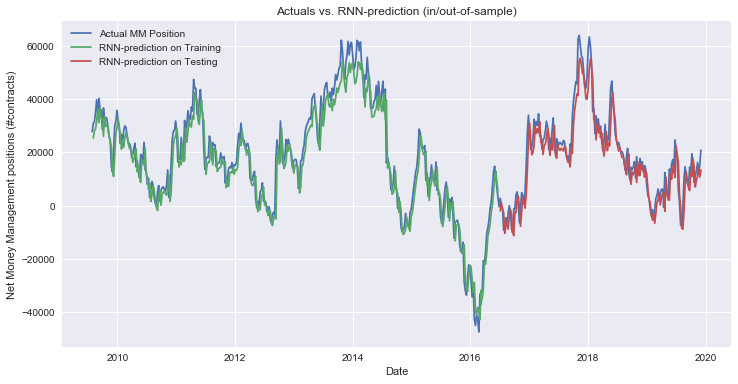

In [19]:
plt.style.use('seaborn')
plt.plot(MM_net_WTI.index, MM_net_WTI.values, label='Actual MM Position')
plt.plot(MM_net_WTI.index[1:len(RNN_y_train_pred)+1], RNN_y_train_pred, label='RNN-prediction on Training')
plt.plot(MM_net_WTI.index[len(RNN_y_train_pred)+2:], RNN_y_test_pred, label='RNN-prediction on Testing')
plt.title('Actuals vs. RNN-prediction (in/out-of-sample)')
plt.xlabel('Date')
plt.ylabel('Net Money Management positions (#contracts)')
plt.legend()
plt.gcf().set_size_inches(12,6)

In [20]:
print('\n# Evaluate on test data')
RNN_results = RNN_model.evaluate(X_test, y_test, batch_size=100)
print('test loss, test acc:', RNN_results)


# Evaluate on test data
179/179 [==============================] - 0s 618us/step
test loss, test acc: 0.01101794782193513


## 4. Long-Short Term Memmory (LSTM)

In [21]:
tf.reset_default_graph()
keras.backend.clear_session()

LSTM_model = Sequential()
LSTM_model.add(LSTM(units=8, input_shape=(X_train.shape[1], X_train.shape[2])))
LSTM_model.add(Dense(1))

LSTM_model.compile(loss='mean_squared_error', optimizer='adam')

LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [22]:
nb_epoch = 50
batch_size = 1

history = LSTM_model.fit(X_train, y_train, 
                        epochs=nb_epoch, 
                        verbose=1, 
                        batch_size=batch_size, 
                        shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
360/360 [==============================] - 2s 6ms/step - loss: 0.0930
Epoch 2/50
360/360 [==============================] - 1s 3ms/step - loss: 0.0275
Epoch 3/50
360/360 [==============================] - 1s 3ms/step - loss: 0.0108
Epoch 4/50
360/360 [==============================] - 1s 3ms/step - loss: 0.0099
Epoch 5/50
360/360 [==============================] - 1s 3ms/step - loss: 0.0098
Epoch 6/50
360/360 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 7/50
360/360 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 8/50
360/360 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 9/50
360/360 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 10/50
360/360 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 11/50
360/360 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 12/50
3

In [23]:
LSTM_y_train_pred = LSTM_model.predict(X_train)
LSTM_y_test_pred = LSTM_model.predict(X_test)

LSTM_y_train_pred = scaler.inverse_transform(LSTM_y_train_pred)
LSTM_y_test_pred = scaler.inverse_transform(LSTM_y_test_pred)


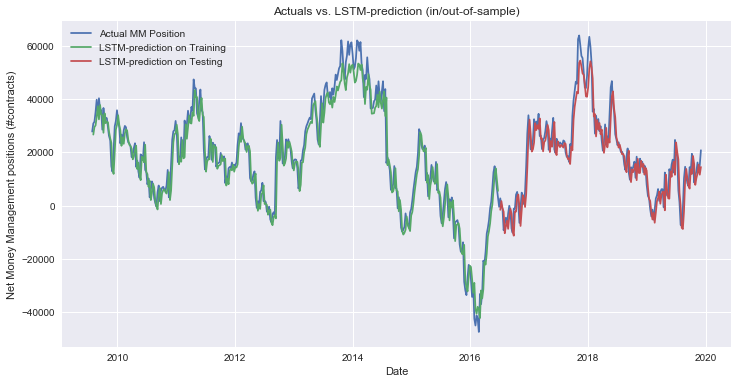

In [24]:
plt.style.use('seaborn')
plt.plot(MM_net_WTI.index, MM_net_WTI.values, label='Actual MM Position')
plt.plot(MM_net_WTI.index[1:len(LSTM_y_train_pred)+1], LSTM_y_train_pred, label='LSTM-prediction on Training')
plt.plot(MM_net_WTI.index[len(LSTM_y_train_pred)+2:], LSTM_y_test_pred, label='LSTM-prediction on Testing')
plt.title('Actuals vs. LSTM-prediction (in/out-of-sample)')
plt.xlabel('Date')
plt.ylabel('Net Money Management positions (#contracts)')
plt.legend()
plt.gcf().set_size_inches(12,6)

In [25]:
print('\n# Evaluate on test data')
LSTM_results = LSTM_model.evaluate(X_test, y_test, batch_size=100)
print('test loss, test acc:', LSTM_results)


# Evaluate on test data
179/179 [==============================] - 0s 1ms/step
test loss, test acc: 0.010139567751499861


# 5. Gated Recurrent Units (GRU)

In [26]:
tf.reset_default_graph()
keras.backend.clear_session()

GRU_model = Sequential()
GRU_model.add(GRU(units=8, batch_input_shape=(1, X_train.shape[1], X_train.shape[2])))
GRU_model.add(Dense(1))
GRU_model.compile(loss='mean_squared_error', optimizer='adam')
GRU_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, 8)                    240       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    9         
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________


In [27]:
nb_epoch = 25
batch_size = 1

history = GRU_model.fit(X_train, y_train, 
                        epochs=nb_epoch, 
                        verbose=1, 
                        batch_size=batch_size, 
                        shuffle=False)

Epoch 1/25
360/360 [==============================] - 2s 4ms/step - loss: 0.0138
Epoch 2/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0097
Epoch 3/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 4/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 5/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 6/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 7/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 8/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 9/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 10/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 11/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 12/25
360/360 [==============================] - 1s 2ms/step - loss: 0.0095
Epoch 13/25
360/360 [====

In [29]:
GRU_y_train_pred = GRU_model.predict(X_train)
GRU_y_test_pred = GRU_model.predict(X_test)

GRU_y_train_pred = scaler.inverse_transform(GRU_y_train_pred)
GRU_y_test_pred = scaler.inverse_transform(GRU_y_test_pred)

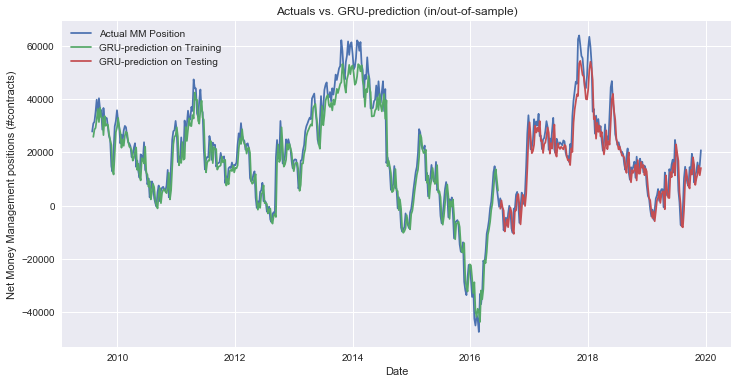

In [30]:
plt.style.use('seaborn')
plt.plot(MM_net_WTI.index, MM_net_WTI.values, label='Actual MM Position')
plt.plot(MM_net_WTI.index[1:len(GRU_y_train_pred)+1], GRU_y_train_pred, label='GRU-prediction on Training')
plt.plot(MM_net_WTI.index[len(GRU_y_train_pred)+2:], GRU_y_test_pred, label='GRU-prediction on Testing')
plt.title('Actuals vs. GRU-prediction (in/out-of-sample)')
plt.xlabel('Date')
plt.ylabel('Net Money Management positions (#contracts)')
plt.legend()
plt.gcf().set_size_inches(12,6)

In [31]:
print('\n# Evaluate on test data')
GRU_results = GRU_model.evaluate(X_test, y_test, batch_size=100)
print('test loss, test acc:', GRU_results)


# Evaluate on test data
179/179 [==============================] - 0s 903us/step
test loss, test acc: 0.010458059041818095


## 6. Summary of results

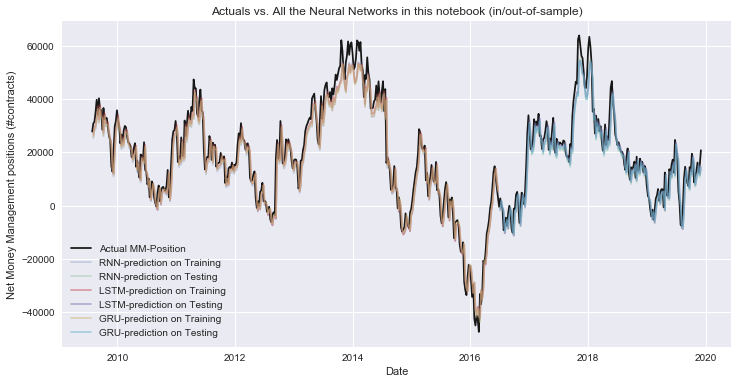

In [32]:
plt.style.use('seaborn')
#plt.style.use('bmh')
plt.plot(MM_net_WTI.index, MM_net_WTI.values, 
         label='Actual MM-Position', 
         color='k',
        alpha=.9)
plt.plot(MM_net_WTI.index[1:len(RNN_y_train_pred)+1], RNN_y_train_pred, 
         label='RNN-prediction on Training',
         alpha=.25,)
plt.plot(MM_net_WTI.index[len(RNN_y_train_pred)+2:], RNN_y_test_pred, 
         label='RNN-prediction on Testing',
         alpha=.25)
plt.plot(MM_net_WTI.index[1:len(LSTM_y_train_pred)+1], LSTM_y_train_pred, 
         label='LSTM-prediction on Training',
         alpha=.5)
plt.plot(MM_net_WTI.index[len(LSTM_y_train_pred)+2:], LSTM_y_test_pred, 
         label='LSTM-prediction on Testing',
        alpha=.5)
plt.plot(MM_net_WTI.index[1:len(GRU_y_train_pred)+1], GRU_y_train_pred, 
         label='GRU-prediction on Training',
        alpha=.5)
plt.plot(MM_net_WTI.index[len(GRU_y_train_pred)+2:], GRU_y_test_pred, 
         label='GRU-prediction on Testing',
        alpha=.5)
plt.title('Actuals vs. All the Neural Networks in this notebook (in/out-of-sample)')
plt.xlabel('Date')
plt.ylabel('Net Money Management positions (#contracts)')
plt.legend()
plt.gcf().set_size_inches(12,6)